In [1]:
import os
os.chdir("../scripts/DCGAN/")

In [26]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
import matplotlib.pyplot as plt 
import numpy as np

Tensor = torch.Tensor

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"


In [27]:
dir(v2)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ClampBoundingBoxes',
 'ColorJitter',
 'Compose',
 'ConvertBoundingBoxFormat',
 'ConvertImageDtype',
 'CutMix',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'Identity',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'MixUp',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChannelPermutation',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomIoUCrop',
 'RandomOrder',
 'RandomPerspective',
 'RandomPhotometricDistort',
 'RandomPosterize',
 'RandomResize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomShortestSize',
 'RandomSolarize',
 'RandomVerticalFlip',
 'RandomZoomOut',
 'Resize',
 'SanitizeBoundingBoxes',
 'ScaleJitter',
 'TenCrop',
 'ToDtype',
 'ToImage',
 'ToPILImage',
 'ToPureTensor',
 'ToTensor',
 

In [3]:
from dcgan_mnist import Discriminator

```python
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=2048, out_features=1, bias=False)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Sigmoid()
  )
)
```

In [142]:
layer_out = None # ugly, we know

LAYER_OBJ = 1
CHANNEL_OBJ = 2
NEURON_OBJ = 3

class Objective():
    def __init__(self, obj_type, layer, **kwargs):
        self.type = obj_type
        self.layer = layer
        if obj_type == LAYER_OBJ:
            pass
        elif obj_type == CHANNEL_OBJ:
            self.channel_index = kwargs["channel_index"]
        elif obj_type == NEURON_OBJ:
            self.neuron_index = kwargs["neuron_index"]
        else:
            raise ValueError("`obj_type` must be one of LAYER_OBJ, CHANNEL_OBJ, NEURON_OBJ.")

class ActivationMaximizer():
    def __init__(self, model, input_shape):
        super().__init__()

        self.model = model
        self.input_shape = input_shape

    def optimize(self, objective, transforms=[], iterations=10, eta=1e-4):
        start = torch.randn(self.input_shape)*0.01
        self.input = torch.nn.Parameter(start.clone(), requires_grad=True)

        def hook(model, input, output):
            global layer_out
            layer_out = output
        
        objective.layer.register_forward_hook(hook)

        optimizer = torch.optim.Adam([self.input], eta)

        for i in range(iterations):
            for t in transforms:
                self.input.data = t(self.input.data)

            self.model.zero_grad()
            self.model.forward(self.input.to(device))

            if objective.type == LAYER_OBJ:        
                loss = -torch.mean(layer_out**2)
            elif objective.type == CHANNEL_OBJ:
                mask = torch.zeros_like(layer_out)
                mask[0, objective.channel_index, :, :] = 1
                loss = -torch.mean((mask * layer_out)**2)
            elif objective.type == NEURON_OBJ:
                mask = torch.zeros_like(layer_out)
                mask[objective.neuron_index] = 1
                loss = -torch.mean((mask * layer_out)**2)

            loss.backward(retain_graph=True)
            optimizer.step()

        return start, self.input

In [202]:
def plotObjectiveMaximization(model, objective, **kwargs):
    maximizer = ActivationMaximizer(discriminator, (1, 28, 28))

    transforms = [
        v2.RandomAffine(0, translate=(0.05, 0.05)),
        v2.RandomAffine(0, scale=(0.9, 1/0.9)),
        v2.RandomRotation(interpolation=v2.InterpolationMode.BILINEAR, degrees=3)
    ]

    start, result = maximizer.optimize(objective, transforms, **kwargs)

    if objective.type == NEURON_OBJ:
        fig, axs = plt.subplots(1, 2)

        fig.suptitle(f"Neuron objective: {objective.neuron_index[1:]}")

        axs[0].imshow(result[0,:,:].detach().numpy(), cmap="inferno")
        axs[0].set_title("Optimized input")
        axs[1].imshow(layer_out.detach().numpy()[objective.neuron_index[:2]], cmap="inferno")
        axs[1].set_title("Channel")

    elif objective.type == CHANNEL_OBJ:
        fig, axs = plt.subplots(1, 2)

        fig.suptitle(f"Channel objective: {objective.channel_index}")

        axs[0].imshow(result[0,:,:].detach().numpy(), cmap="inferno")
        axs[0].set_title("Optimized input")
        axs[1].imshow(layer_out.detach().numpy()[0, objective.channel_index], cmap="inferno")
        axs[1].set_title("Channel")

    elif objective.type == LAYER_OBJ:
        fig, ax = plt.subplots(1, 1)

        fig.suptitle(f"Layer objective")

        ax.imshow(result[0,:,:].detach().numpy(), cmap="inferno")
        ax.set_title("Optimized input")

    plt.tight_layout()
    plt.show()

    # plt.imshow(torch.tanh(start[0,:,:]*10000))
    # plt.show()
    

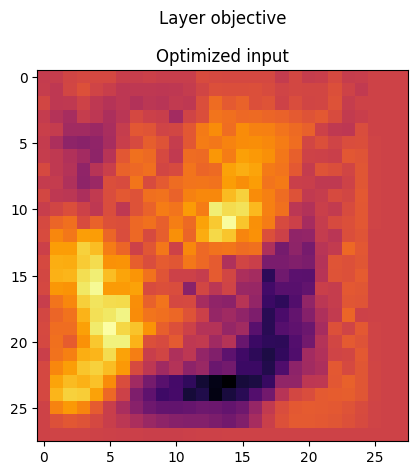

In [203]:
discriminator = torch.load("../../models/DCGAN/mnist-gan-discriminator.pt", map_location=torch.device(device))

objective = Objective(LAYER_OBJ, discriminator.main[10])

plotObjectiveMaximization(discriminator, objective, iterations=3000, eta=1e-3)

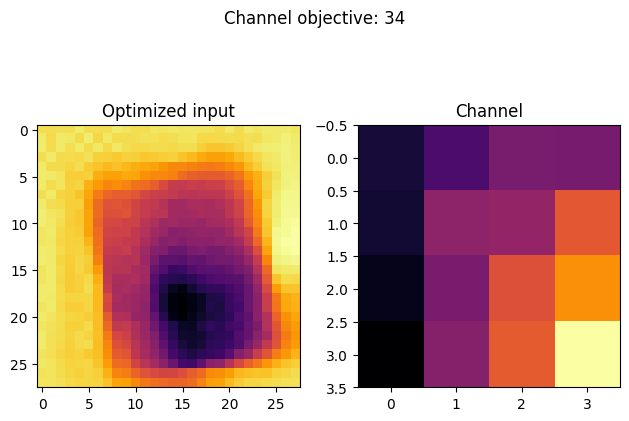

In [204]:
discriminator = torch.load("../../models/DCGAN/mnist-gan-discriminator.pt", map_location=torch.device(device))

objective = Objective(CHANNEL_OBJ, discriminator.main[3], channel_index=34)

plotObjectiveMaximization(discriminator, objective, iterations=3000, eta=1e-3)

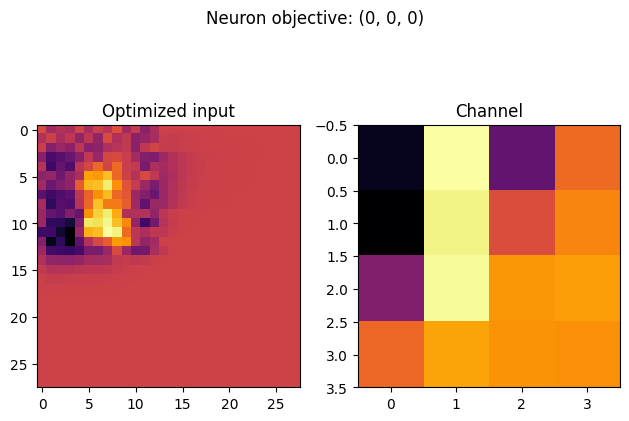

In [205]:
discriminator = torch.load("../../models/DCGAN/mnist-gan-discriminator.pt", map_location=torch.device(device))

objective = Objective(NEURON_OBJ, discriminator.main[3], neuron_index=(0, 0, 0, 0))

plotObjectiveMaximization(discriminator, objective, iterations=3000, eta=1e-3)

In [77]:
im = result[0,:,:].detach().numpy()
np.max(im), np.min(im)

(0.017791009, -0.025771398)